In [1]:
################################################
# Ayoub Sikouky
# Title: SISR Using a Multi Model System
# Edit Date: 23/04/2022
################################################
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Rescaling, Add, Lambda, Flatten, Dense, LeakyReLU, BatchNormalization 
from tensorflow.keras.losses import MeanAbsoluteError, binary_crossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from PIL import Image
from typing import List

## I - Data

### 1.1 : Helper Functions

In [2]:
def download_data(f_name, dst, source_url):
    """
    Download and unzip datastes.
    #### Args:
    f_name: zip file name.
    dst: The destination directory where the files will be stored.
    source_url: The URL for the dataset.
    """
    file_url = os.path.join(source_url, f_name)
    dst_abspath = os.path.abspath(dst)
    tf.keras.utils.get_file(f_name, file_url, cache_subdir=dst_abspath, extract=True)
    # Removing the zip file.
    os.remove(os.path.join(dst_abspath, f_name)) 


def get_paths(dirs: List[str], path_type):
    """
    Retuns a list of images' paths inside a directories 
    that have "path_type" in their name.
    #### Args:
    dirs: The list of directories to be searched.
    path_type: The "characters" to selcet which directories to search for images.
    """
    if not isinstance(dirs, list):
      raise Exception("'dirs' argument must be a list.")

    paths_list = [] # List of paths in "dirs"
    subpaths_lists = [] # List of lists of images' paths.
    for d in dirs:
        if path_type in str(d):
            paths_list.append(d)
    paths_list.sort()
    
    if len(paths_list) == 1:
        img_paths = [str(f) for f in paths_list[0].glob("**/*.png")]
        img_paths.sort()
        return img_paths
    else:
      for main_path in paths_list:
        tmp_subpath_list = [str(f) for f in main_path.glob("**/*.png") if f.is_file]
        tmp_subpath_list.sort()
        subpaths_lists.append(tmp_subpath_list)

    return subpaths_lists

### 1.2: Preparing the Data

#### 1.2.1 Download Data (if needed)

In [3]:
# Downloading the datasets used in training and validation.
if not os.path.exists("Original_Datasets/DIV2K"):

    DIV2K_URL = "http://data.vision.ee.ethz.ch/cvl/DIV2K/"
    DIV2K_FILE_NAMES = ["DIV2K_train_HR.zip", "DIV2K_valid_HR.zip", 
                        "DIV2K_train_LR_bicubic_X2.zip", "DIV2K_valid_LR_bicubic_X2.zip"]
    dst_dir = "Original_Datasets/DIV2K"

    for file in DIV2K_FILE_NAMES:
        download_data(file, dst_dir, DIV2K_URL)
else:
    print("'Original_Datasets/DIV2K' Exists")

'Original_Datasets/DIV2K' Exists


#### 1.2.2 Data Paths

In [4]:
# Check if colab is used.
using_google_colab = "google.colab" in str(get_ipython())

## When Using Google Colab
if using_google_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  colab_path = "/content/drive/MyDrive/ARU's Master/Application Of Machine Learning/Assignments/Super_Resolution/"
  ALL_DATA_PATH = Path(colab_path+"Original_Datasets")
  CHECKPOINT_PATH = colab_path + "training_checkpoints/"
  MODELS_PATH = colab_path + "Models/"

else:
## When Using Local Machine.
  ALL_DATA_PATH = Path(r"Original_Datasets")
  CHECKPOINT_PATH = "training_checkpoints/"
  MODELS_PATH = "Models/"

In [5]:
SCALE = 2 # The scale of the downsample images used.
SCALING_TO_UPSAMPLE = {2: 1, 3: 1, 4: 2}

# Getting all sub directories inside the working directory.
all_paths = ALL_DATA_PATH.glob("**/*")
dirs = [d for d in all_paths if d.is_dir()]

# Selecting HR (High Resolution) directories.
all_sub_paths = get_paths(dirs, "HR")

# 
HR_TRAIN_PATH, HR_VALID_PATH = all_sub_paths[0], all_sub_paths[1]
print(f"HR Train Len: {len(HR_TRAIN_PATH)}")
print(f"HR Valid Len: {len(HR_VALID_PATH)}")
print(f"HR Train Paths Example:\n{HR_TRAIN_PATH[:2]}")

LR_TRAIN_PATH, LR_VALID_PATH = get_paths(dirs, f"X{SCALE}")
print(f"LR Train Len: {len(LR_TRAIN_PATH)}")
print(f"LR Valid Len: {len(LR_VALID_PATH)}")
print(f"LR Train Paths Example:\n{LR_TRAIN_PATH[:2]}")

HR Train Len: 800
HR Valid Len: 100
HR Train Paths Example:
['Original_Datasets/DIV2K/DIV2K_train_HR/0001.png', 'Original_Datasets/DIV2K/DIV2K_train_HR/0002.png']
LR Train Len: 800
LR Valid Len: 100
LR Train Paths Example:
['Original_Datasets/DIV2K/DIV2K_train_LR_bicubic/X2/0001x2.png', 'Original_Datasets/DIV2K/DIV2K_train_LR_bicubic/X2/0002x2.png']


#### 1.2.3 Creating the datasets used in the models

In [6]:
def load_img(file_name:str):
    """
    Read and load an image (Dtype=int32)from a file name.
    #### Args:
    file_name: The image file name.
    """
    img = tf.image.decode_image(tf.io.read_file(file_name), channels=3)
    return tf.cast(img, tf.int32)

def random_crop(lr_img, hr_img, hr_crop_size, scale, same_size=False):
    """
    Randomly crop images.
    #### Args:
    lr_img: Low-resolution image.
    hr_img: High-resolution image.
    hr_crop_size: The crop size for the HR image.
    scale: The scale of the LR image wrt HR image.
    same_size: Wehther the images have the same size.
    """
    hr_shape = tf.shape(hr_img)
    
    # To include the last columns and rows of pixels '+ 1' is needed.
    # Dtype is int32 to be able to use indices to crop the image.
    # Randomly selecting a value between [0 and hr_crop_size+1).
    hr_top = tf.random.uniform(shape=(), maxval=hr_shape[0] - hr_crop_size + 1, dtype=tf.int32)
    hr_left = tf.random.uniform(shape=(), maxval=hr_shape[1] - hr_crop_size + 1, dtype=tf.int32)

    # Calculating the crop size for low resolution image.
    if not same_size:
        lr_crop_size = hr_crop_size // scale
        lr_top = hr_top // scale
        lr_left = hr_left // scale
    else:
        lr_crop_size = hr_crop_size
        lr_top = hr_top
        lr_left = hr_left

    # Cropping the images.
    lr_img_crop = lr_img[lr_top:lr_top + lr_crop_size, lr_left:lr_left + lr_crop_size]
    hr_img_crop = hr_img[hr_top:hr_top + hr_crop_size, hr_left:hr_left + hr_crop_size]

    return lr_img_crop, hr_img_crop

def random_flip(lr_img, hr_img):
    """
    Randomly flip the image horizantally and vertically.
    #### Args:
    lr_img: Low resolution image.
    hr_img: High resolution image.
    """
    rng = np.random.default_rng()
    # Horizantal Flip
    ran_value = rng.uniform(low=0, high=1, size=1)[0]
    if ran_value >= 0.5:
        lr_img = tf.image.flip_left_right(lr_img)
        hr_img = tf.image.flip_left_right(hr_img)
    # Vertical Flip
    ran_value = rng.uniform(low=0, high=1, size=1)[0]
    if ran_value >= 0.5:
        lr_img = tf.image.flip_up_down(lr_img)
        hr_img = tf.image.flip_up_down(hr_img)
    return lr_img, hr_img

def random_rotation(lr_img, hr_img):
    """
    Randomly rotate the image.
    #### Args:
    lr_img: Low resolution image.
    hr_img: High resolution image.
    """
    rng = np.random.default_rng()
    ran_value = rng.uniform(low=0, high=1, size=1)[0]
    if ran_value >= 0.5:
        num_rot = rng.integers(low=0, high=4, size=1)[0]
        """
        num_rot:
        0 rotation, 0 degrees.
        1 rotation, 90 degrees.
        2 rotations, 180 degrees.
        3 rotations, 270 degrees.
        """
        lr_img = tf.image.rot90(lr_img, k=num_rot)
        hr_img = tf.image.rot90(hr_img, k=num_rot)
    return lr_img, hr_img 

def convert_dtype(lr_img, hr_img, dtype=tf.float32):
    """
    Convert the type of images.
    #### Args:
    lr_img: Low resolution image.
    hr_img: High resolution image.
    dtype: The new type of images.
    """
    lr_img = tf.cast(lr_img, dtype)
    hr_img = tf.cast(hr_img, dtype)
    return lr_img, hr_img

def create_dataset(lr_paths: List[str], hr_paths: List[str], batch_size:int=16, 
                   crop_size=96, scale:int=None, same_size=False, apply_trans=True, repeat=None):
    """
    Create an optimised dataset to be used with a model.
    #### Args:
    lr_paths: List of Low-resolution images.
    hr_paths: List of High-resolution images.
    batch_size: The batch size used in the dataset.
    crop_size: The crop size used for cropping the HR images; deafult=96.
    scale: The scaling factor. 
    same_size: Wehther the images have the same size.
    apply_trans: Whether to apply transformations; default=True.
    repeat: The number of time the dataset will be repeated;
             deafult=None, the dataset will be repeated indefinitely.
    """
    
    if not scale or scale < 2:
        raise ValueError(f"Scale must be an integer and >= 2, got '{scale}'")

    # A variable used by tensorflow data API to 
    # dynamically select the best value for its operation.
    AUTOTUNE = tf.data.AUTOTUNE 

    imgs_paths = [lr_paths, hr_paths]
    dataset_list = []

    for type_path in imgs_paths:
        tmp_ds = tf.data.Dataset.from_tensor_slices(type_path)
        tmp_ds = tmp_ds.map(load_img, num_parallel_calls=AUTOTUNE)
        dataset_list.append(tmp_ds)

    # Creating the dataset by zipping together the LR and HR datasets.
    dataset = tf.data.Dataset.zip((dataset_list[0], dataset_list[1]))

    # Performing data augmentation.
    if apply_trans:
        dataset = dataset.map(lambda lr, hr: random_crop(lr, hr, crop_size, scale, same_size=same_size), num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(random_flip, num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(random_rotation, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(convert_dtype, num_parallel_calls=AUTOTUNE) # Converting images to float32.
    dataset = dataset.repeat(repeat) # Keeps generating data.
    dataset = dataset.prefetch(AUTOTUNE) # prefecth data to speedup training.
    return dataset

In [ ]:
BATCH_SIZE = 16

train_dataset = create_dataset(LR_TRAIN_PATH, HR_TRAIN_PATH, batch_size=BATCH_SIZE, 
                               crop_size=96, scale=SCALE, same_size=False, apply_trans=True)

valid_dataset = create_dataset(LR_VALID_PATH, HR_VALID_PATH, batch_size=1, 
                                scale=SCALE, apply_trans=False, repeat=1)

2022-04-23 21:35:21.251776: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


LR Batch: 
(TensorShape([16, 48, 48, 3]), tf.float32)
HR Batch: 
(TensorShape([16, 96, 96, 3]), tf.float32)


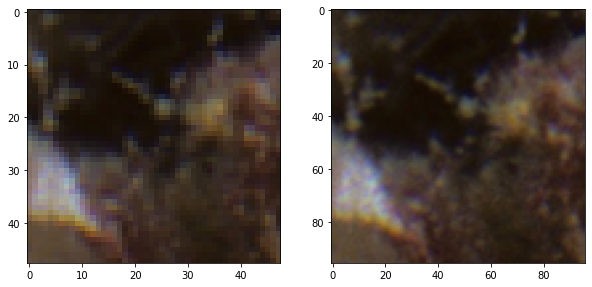

In [8]:
# Example of the produced datasets.
for img_batch in train_dataset.take(1):
    lr_batch, hr_batch = img_batch
    # gg_lr = tf.clip_by_value(gg_lr_btch[0], 0, 255)
    # gg_hr = tf.clip_by_value(gg_hr_btch[0], 0, 255)
    lr_img = lr_batch[0]
    hr_img = hr_batch[0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.cast(lr_img, tf.uint8))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.cast(hr_img, tf.uint8))
    
    print(f"LR Batch: \n{lr_batch.shape, lr_batch.dtype}")
    print(f"HR Batch: \n{hr_batch.shape, hr_batch.dtype}")

## II - Models

### 2.1 Helper Functions

In [9]:
################### General Helper Functions ################### 
def psnr_metric(org_img, up_img):
    """
    Calculate PSNR between the two images.
    #### Args:
    org_img: Original image.
    up_img: Upsampled image.
    """
    return tf.image.psnr(org_img, up_img, max_val=255)

def ssim_metric(org_img, up_img):
    """
    Calculate SSIM between the two images.
    #### Args:
    org_img: Original image.
    up_img: Upsampled image.
    """
    return tf.image.ssim(org_img, up_img, max_val=255)

def plot_metric(m_history, metric: str, val=True):
  """
  Plots a metric of a model.
  #### Args:
  m_history: Model History.
  metric: The metric name to plot.
  val: Whether to include the validation metrics.
  """
  train_metric = m_history.history[metric]
  if val:
    val_metric = m_history.history["val_"+metric]

  num_epochs = range(1, len(train_metric)+1)
  plt.plot(num_epochs, train_metric)
  if val:
    plt.plot(num_epochs, val_metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  if val:
    plt.title(f"Train and Validation: {metric}")
    plt.legend(["Train", "Validation"], loc="best")
  else:
    plt.title(f"Train : {metric}")
    plt.legend(["Train"], loc="best")
  
  plt.show()

def multi_save(t_model, model_fname: str, model_dir: str, t_history, show_dir=False):
    """
    Save the model, and its history as a json file.
    #### Args:
    t_model: Model to save.
    model_name: The name given to the model.
    model_dir: Directory where the to save the model and history file.
    t_history: Model history.
    """
    try:
        # Model name without the extinsion
        m_name = model_fname.split('.')[0]

        t_model.save(model_dir+model_fname)
        print(f"{m_name} Was saved.")
        
        with open(model_dir+f"{m_name}_t_history_dict.json", 'w') as th_file:
            json.dump(t_history.history, th_file)
        print(f"{m_name} history was saved.")
        if show_dir:
          print(f"Model and history were saved in: '{model_dir}'")
    except Exception as e:
        print(e)

### 2.2 Base Model

In [10]:
def get_upsample_num(scaling_dict, scale):
    """
    Return the number of upscaling blocks needed based on the scale factor.
    #### Args:
    scaling_dict: A dictionary for mapping scaling factors to the number 
                  of upscaling needed to achieve the upscaling.
    scale: The sacle factor.
    """
    try:
        return scaling_dict[scale]
    except KeyError:
        raise KeyError("Only 2, 3, and 4 are supported as a scale.")

def create_resblock(in_layer, num_filters, kernel_size=3):
    """
    Build the residual blocks.
    #### Args:
    in_layer: Layer to build on top of it.
    num_filters: Number of filters in the convolutional layer.
    kernel_size: The kernel size in the convolutional layer.
    """
    x = Conv2D(num_filters, kernel_size=kernel_size, padding="same", activation="relu")(in_layer)
    x = Conv2D(num_filters, kernel_size, padding="same")(x)
    x = Add()([in_layer, x])
    return x
    
def upsample_block(in_layer, num_filters, scale):
    """
    Build the upsampling blocks.
    #### Args:
    in_layer: Layer to build on top of it.
    num_filters: Number of filters in the convolutional layer.
    scale: Scaling factor.
    """
    x = Conv2D(num_filters*(scale**2), kernel_size=3, padding='same')(in_layer)
    x = Lambda(lambda z: tf.nn.depth_to_space(z, scale))(x)
    return x

def create_base_model(scale, scaling_dict, filters=64, k_size=9, resblocks=16):
    """
    Build the base model.
    #### Args:
    scale: Scaling factor.
    scaling_dict: A dictionary for mapping scaling factors to the number 
                  of upscaling needed to achieve the upscaling.
    filters: Number of filters in the convolutional layers.
    k_size: Kernel size used in the first convolutional layer.
    resblocks: Number of residual blocks.
    """
    if not scale or scale < 2:
        raise ValueError(f"Scale must be an integer and >= 2, got '{scale}'")
    # Number of upscaling factors.
    n_upscaling_blocks = get_upsample_num(scaling_dict, scale)

    ######################## Initial Part ########################
    x_input = Input(shape=(None, None, 3))
    # Normalising the image to [-1, 1]
    x = Rescaling(1./127.5, offset=-1)(x_input)
    x = conv1 = Conv2D(filters=filters, kernel_size=k_size, 
                        padding="same", activation="relu")(x)

    ######################## Residual Part ########################
    # Creating the residual blocks.
    for _ in range(resblocks):
        x = create_resblock(x, num_filters=filters, kernel_size=3)
    
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = Add()([conv1, x])

    ######################## Upsampling Part ########################
    if scale % 2 == 0:
        scale = 2
    for _ in range(n_upscaling_blocks):
        x = upsample_block(x, filters, scale)

    ######################## Output ########################
    x = Conv2D(3, k_size, padding="same")(x)
    return Model(inputs=x_input, outputs=x)

In [11]:
base_model = create_base_model(SCALE, SCALING_TO_UPSAMPLE, filters=64, k_size=9, resblocks=16)

In [12]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   15616       ['rescaling[0][0]']              
                                64)                                                           

In [ ]:
#tf.keras.utils.plot_model(base_model)

In [13]:
# Callbacks
my_checkpoint_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH+"base_model/model.{epoch:02d}-{val_loss:.2f}", 
                                         save_weights_only=True,
                                         monitor="val_loss",
                                         mode='min',
                                         save_best_only=True,
                                         initial_value_threshold=7.0)

my_callbacks = [my_checkpoint_callback]


training_updates = 12500
steps_per_epoch = 50
training_epochs = int(training_updates / steps_per_epoch)
print(f"Total training Epochs: {training_epochs}")

Total training Epochs: 250


In [14]:
# 1e-4 from epoch 0 to 200. 
# 1e-5 from epoch 201 to 250.
learning_rate = PiecewiseConstantDecay([10000], [1e-4, 1e-5]) 
base_model.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,epsilon=1e-8), 
                   loss=MeanAbsoluteError(), 
                   metrics=[psnr_metric])

In [15]:
history = base_model.fit(train_dataset,validation_data=valid_dataset.take(10), 
                         steps_per_epoch=steps_per_epoch, epochs=training_epochs, callbacks=my_callbacks)

Epoch 1/250


2022-04-23 09:42:02.723842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 94.6858 - psnr_metric: 10.7517

2022-04-23 09:42:12.599654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 24s 445ms/step - loss: 94.6858 - psnr_metric: 10.7517 - val_loss: 44.2077 - val_psnr_metric: 13.3926
Epoch 2/250
50/50 [==============================] - 24s 482ms/step - loss: 42.9774 - psnr_metric: 14.3707 - val_loss: 39.0122 - val_psnr_metric: 14.5430
Epoch 3/250
50/50 [==============================] - 22s 452ms/step - loss: 36.7275 - psnr_metric: 15.6729 - val_loss: 32.2297 - val_psnr_metric: 16.1289
Epoch 4/250
50/50 [==============================] - 22s 452ms/step - loss: 27.0545 - psnr_metric: 18.1061 - val_loss: 21.6544 - val_psnr_metric: 19.1871
Epoch 5/250
50/50 [==============================] - 22s 455ms/step - loss: 24.0003 - psnr_metric: 19.1516 - val_loss: 21.0338 - val_psnr_metric: 19.4430
Epoch 6/250
50/50 [==============================] - 22s 452ms/step - loss: 21.4486 - psnr_metric: 20.1488 - val_loss: 19.5776 - val_psnr_metric: 20.1230
Epoch 7/250
50/50 [==============================] - 25s 495ms/step - loss: 18.7093 - ps

In [16]:
multi_save(base_model, "2X_base_model.h5", MODELS_PATH, history, show_dir=True)

2X_base_model Was saved.
2X_base_model history was saved.
Model and history were saved in: 'Models/'


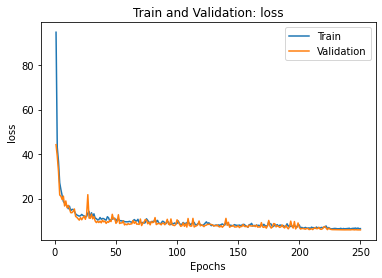

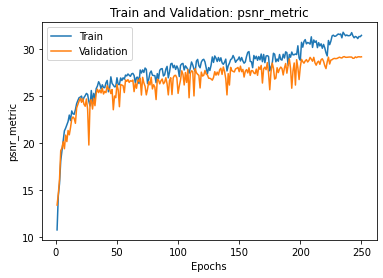

In [17]:
plot_metric(history, "loss")
plot_metric(history, "psnr_metric")

### 2.3 GAN Model

## III - Evaluation

### 3.1 Helper Functions

In [18]:
def resize_img(img, img_size, dtype=tf.float32):
    """
    Resise an image to the specified new size.
    #### Args:
    img: The supplied image.
    img_size: New image size.
    dtype: The output image type.
    """
    img = tf.cast(img.numpy(), tf.uint8).numpy()
    img = np.asarray(Image.fromarray(img).resize(img_size, resample=Image.BICUBIC))
    img = tf.clip_by_value(img, 0, 255)
    img = tf.cast(img, dtype)
    return img

def calculate_metrics_list(imgs_paths: List[str], scale: int, model):
    """
    Calculate PSNR and SSIM for all images supplied.
    #### Args:
    imgs_paths: A list of images path.
    scale: The sacling factor to use.
    model: A trained model to generate images.
    """
    if not scale or scale < 2:
        raise ValueError(f"'Scale' must be an integer and >= 2; got {scale}")
    num_imgs = len(imgs_paths)
    total_psnr_bicubic = 0
    total_ssim_bicubic = 0
    total_ssim_model = 0
    total_psnr_model = 0

    for img_path in imgs_paths:
        orig_img = load_img(img_path)
        orig_img = tf.cast(orig_img, dtype=tf.float32)

        lr_height = orig_img.shape[0]//scale
        lr_width = orig_img.shape[1]//scale

        # Hot Fix for images with odd width, height.
        if orig_img.shape[0] % 2 != 0 or orig_img.shape[1] % 2 != 0:
            orig_img = tf.image.resize(orig_img, [lr_height*scale, lr_width*scale])

        # Creatng the low resolution image.
        lr_img = resize_img(orig_img, (lr_width, lr_height))
        
        # Upscaling the LR image using bicubic.
        hr_bicubic = resize_img(lr_img, (orig_img.shape[1], orig_img.shape[0]))

        # Upscaling the LR image using the model.
        hr_model_upsampling = model.predict(tf.expand_dims(lr_img, axis=0))
        hr_model_upsampling = tf.squeeze(hr_model_upsampling, axis=0)
        hr_model_upsampling = tf.clip_by_value(hr_model_upsampling, 0, 255)
        
        # Calculating PSNR and SSIM for bicubic and model generated images.
        total_psnr_bicubic += tf.image.psnr(orig_img, hr_bicubic, 255).numpy()
        total_ssim_bicubic += tf.image.ssim(orig_img, hr_bicubic, 255).numpy()
        total_ssim_model += tf.image.ssim(orig_img, hr_model_upsampling, 255).numpy()
        total_psnr_model += tf.image.psnr(orig_img, hr_model_upsampling, 255).numpy()

    
    avg_psnr_bicubic = total_psnr_bicubic / num_imgs
    avg_ssim_bicubic = total_ssim_bicubic / num_imgs
    avg_psnr_model = total_psnr_model / num_imgs
    avg_ssim_model = total_ssim_model / num_imgs

    return avg_psnr_bicubic, avg_psnr_model, avg_ssim_bicubic, avg_ssim_model

def perform_tests(model, test_dirs, scale, all_dirs):
    """
    Perform a series of test using the model and the datasets provided.
    #### Args:
    model: The model to be used.
    test_dirs: The name of the test directories.
    scale: The sacling factor.
    all_dirs: The main directory for datasets.
    """
    # Check if test_dirs is a list.
    if not isinstance(test_dirs, list):
        test_dirs = [test_dirs]

    results = []
    for dir_name in test_dirs:
        test_path = get_paths(all_dirs, dir_name)
        bi_psnr, model_psnr, bi_ssim, model_ssim = calculate_metrics_list(test_path, scale, model)
        psnr_values = {"Test_DIR": dir_name, 
                        "Bicubic_PSNR": f"{bi_psnr:.2f}",
                        "Model_PSNR": f"{model_psnr:.2f}",
                        "Bicubic_SSIM": f"{bi_ssim:.2f}",
                        "Model_SSIM": f"{model_ssim:.2f}"}
        
        results.append(psnr_values)

    return results

### 3.2 Evaluating the models

#### 3.2.1 Base Model

In [ ]:
base_model_name = "2X_base_model.h5"
if not base_model:
    base_model = load_model(MODELS_PATH+base_model_name, custom_objects={"psnr_metric": psnr_metric})

In [21]:
base_model_eval_results = perform_tests(base_model, ["Set5", "Set14", "BSDS100", "Urban100"], SCALE, dirs)

In [22]:
for result in base_model_eval_results:    
    print(result)

{'Test_DIR': 'Set5', 'Bicubic_PSNR': '31.79', 'Model_PSNR': '28.27', 'Bicubic_SSIM': '0.91', 'Model_SSIM': '0.85'}
{'Test_DIR': 'Set14', 'Bicubic_PSNR': '28.59', 'Model_PSNR': '26.01', 'Bicubic_SSIM': '0.85', 'Model_SSIM': '0.78'}
{'Test_DIR': 'BSDS100', 'Bicubic_PSNR': '31.31', 'Model_PSNR': '28.65', 'Bicubic_SSIM': '0.89', 'Model_SSIM': '0.85'}
{'Test_DIR': 'Urban100', 'Bicubic_PSNR': '25.43', 'Model_PSNR': '23.48', 'Bicubic_SSIM': '0.83', 'Model_SSIM': '0.77'}


#### 3.2.2 GAN Model